<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab05_bayes/Pitch2Gender.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a> 
# BAYESIAN CLASSIFICATION using UNIVARIATE GAUSSIAN MODELS
### CASE STUDY: Recognize Gender from Pitch
___   
- database: Hillenbrand-95
- data modeling: gaussian distribution (1 Gaussian per class)
- inference: Bayesian

The [Hillenbrand database](https://homes.esat.kuleuven.be/~spchlab/data/hillenbrand/README.txt) contains segmental pitch estimates (segment is here defined as a vowel)  
We make use of the scikit-learn toolkit and our own pyspch wrapper around it.

In [33]:
####################################################################################
### This setting is to avoid memory leaks in sklearn KMEANS on windows+MKL machines 
### This must be executed before importing numpy (here or in other packages) 
import os
os.environ["OMP_NUM_THREADS"] = '2' 
import warnings
warnings.filterwarnings("ignore")
####################################################################################

In [34]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [35]:
#
%matplotlib inline
import sys,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
#from cycler import cycler
import seaborn as sns

# imports from the scikit-learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture

import pyspch.core as Spch
from pyspch.core.hillenbrand import fetch_hillenbrand, select_hillenbrand
from pyspch.stats import GMM
import pyspch.display as Spd   # sets some plotting preferences
colors = Spd.colors
np.set_printoptions(precision=2)

### 1. The Database 
For the experiments in the notebook we select all adult data and the database fields gender and f0.    

You can use the pitch measurements in 'Hz' which is done by default.
By setting the parameter freq_scale to 'semitones' you can change the observation to the semitone scale.


In [36]:
hildf = fetch_hillenbrand(genders='adults').dropna()
data = select_hillenbrand(hildf,genders='adults')[['gender','f0']]
y = data['gender'].values
X_Hz = data['f0'].values.reshape(-1,1)
classes = ['m','w']

In [37]:
# setting the freq_scale parameter decides if you model pitch frequency as 'Hz' or as 'semitones'
# semitones are expressed relative to a base tone of 50 Hz
freq_scale = 'Hz' 
#freq_scale = "semitones" 
f0base = 50.                         # reference frequency (in Hz) for semitone scale
def freq2st(f,base=f0base):
    return 12*np.log2(f/base)
if freq_scale == 'Hz': X = X_Hz
elif freq_scale == 'semitones': X = freq2st(X_Hz)

### 2. Modeling Pitch data with a Gaussian Model

In the first set of experiments we focus on modeling f0, and later recognizing gender on the basis of it.
If we may assume that all our data has been (correctly) labeled, then we can get view of the data 'per class'. For 1-D observations, as in this case, we observe with histograms.
The plot below shows a simple 2 class histogram  and a Gaussian fit.

We use the GaussianMixture() functions from the sklearn package to model each of the histograms by a (single) Gaussian.

It may all look simple and trivial. However, some intuitive assumptions may be questioned.  We will explore two potential issues:  the number of bins in the histogram and the scaling of the feature axis.

#### Tasks & Questions (1):
1. The principle parameter that you can adjust in the code block below is the 'n_bins' parameter.  It sets the number of bins in the histograms.  There is no ABSOLUTE truth value for n_bins. Try to explain how n_bins is related to the size of your database, the number of classes and/or the dimensionality of the feature vectors ?
2. Up till now we expressed pitch in the common physical unit 'Hz'.  However, from a musical perspective it is more common to express pitch on a musical/logarithmic scale.  In Western music an octave is divided into 12 equal parts on a logartihmic scale, also called *semitones*. Be aware that such musical scale, just as any other logarithmic scale, is a relative scale.  Do you see differences in how the data is distributed on a Hz or on a semitone scale ?  Is the Gaussian assumption work better for either scale ?  

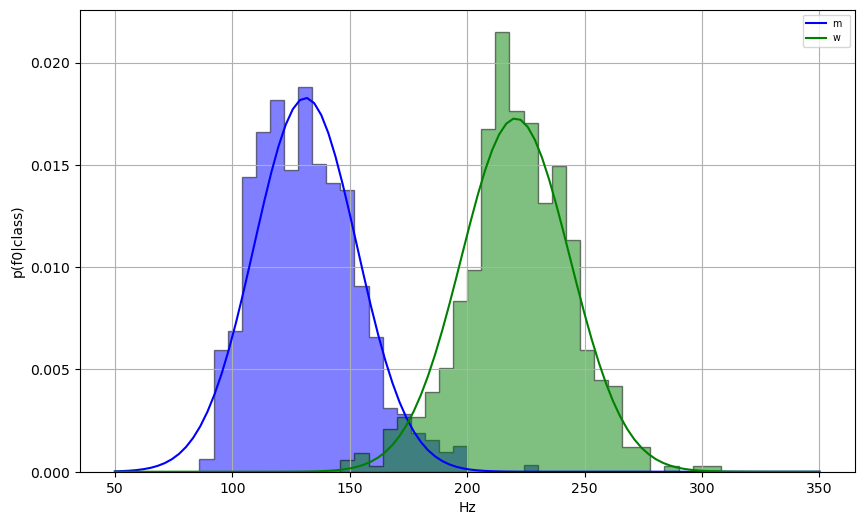

In [42]:
fit_gaussians = True                 # should be True or False
#
n_bins = 50                          # number of bins in the histograms
f0_range = np.asarray([50., 350.])   # frequency range in histograms
if freq_scale == 'semitones':
    f0_range = freq2st(f0_range)
#
x1 = X[y=='m',:]
x2 = X[y=='w',:]
y1 = y[y=='m']
y2 = y[y=='w']

xlab = freq_scale
ylab = 'p(f0|class)'

fig,ax = plt.subplots(figsize=(10,6))
kwargs = dict(histtype='stepfilled', alpha=.5, bins=n_bins, density=True, ec="k")
ax.hist(x1, **kwargs,range=f0_range ,color=colors[0])
ax.hist(x2, **kwargs,range=f0_range ,color=colors[1])
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
ax.grid(True)
if(fit_gaussians):

    xp  = np.linspace(f0_range[0],f0_range[1],100).reshape(-1,1)
    for j in range(0,2):
        if(j==0):
            xdata = x1
        else:
            xdata = x2
        gmm = GaussianMixture(max_iter=3,random_state=1,n_components=1,init_params='kmeans')
        gmm.fit(xdata)
        yp = gmm.score_samples(xp)
        ax.plot(xp,np.exp(yp),label='%s ' % classes[j],color=colors[j])
    ax.legend(loc='upper right',fontsize='x-small')
plt.show()

### 3. Using the Gaussian models in a Bayesian classifier

We know now enough to create and test our classifier
1. split the data in  training set and  test set
    -  X_train, y_train, X_test, y_test
2. train the classifier based on the training data
    - given the data exploration before we choose to model the data in each class with a single Gaussian distribution 
3. construct a classifier using the Bayesian rule and posteriors
4. evaluate on test data; look at overall score 
5. look more in detail to a confusion matrix (next codeblock)

For this, we will use the class *GMM* which is provided in *pyspch.stats*.
It is a class that supports a set of GaussianMixture distributions as used above.
It is implemented as an extension to *sklearn* with the same API. Actually for these experiments we always use a single Gaussian per class as this fits the data well.

There are a number of parameters that you may adjust in the following code blocks
- train_size:    the proportion of the data that will be used for training, the remainder is used for testing
- priors_test:   the a priori probabilities of the classes to be used during test
- random_state:  you can modify this to have a different division between train and test sets and see if you get different results

#### Task & Questions (2)
1. What Accuracy do you obtain ?
2. Do you observe great variability on accuracy when you modify the amount of training data that is used ?  What does this tell you ?
3. Specify different priors for you test classes by modifying parameter *priors_test* (default was None):
    + (i)  specify 80% prior for males 
    + (ii) specify 100% prior for female   
What happens to the overall accuracy and confusion matrix ? Explain why things are going worse.

In [39]:
# --------------
n_components = 1
train_size=0.5
random_state=0     # sets initialization of RNG for selecting train/test data, set to None to be random
priors_test = None # should be None or a vector of type e.g. [0.8 , 0.2] expects 80% male
# --------------
# 1. select non-overlapping train and test sets
test_size=1.0 - train_size
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=test_size, random_state=random_state)
clf_GMM = GMM(classes=classes,n_components=n_components)
clf_GMM.fit(X_train,y_train)
# 2. print the model
clf_GMM.print_model()
y_pred = clf_GMM.predict(X_test,priors=priors_test)
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))

Class[0] (m) with prior=0.495
-----------------------------------
   weights        mean         cov
0      1.0  130.481481  423.049658

Class[1] (w) with prior=0.505
-----------------------------------
   weights        mean         cov
0      1.0  221.145455  497.477026

Accuracy: 94.86%


### Confusion Matrix
A confusion matrix gives a more detailed image of the errors that we make.   
The global accuracy averages over all confusable pairs, while a confusion matrix will hint to more and less confusable pairs or it may also hint at asymmetry in the recognizer.

Accuracy: 94.86%


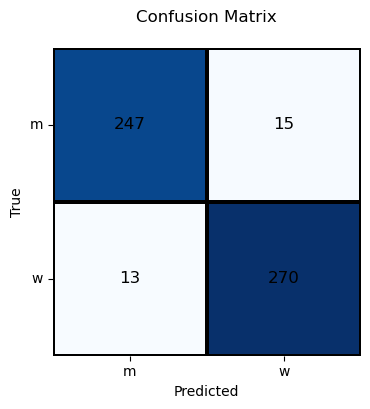

In [40]:
y_pred = clf_GMM.predict(X_test, priors=[.5 , .5])
cf_mat = skmetrics.confusion_matrix(y_test,y_pred,labels=classes) 
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))    
Spch.plot_confusion_matrix(cf_mat,labels=classes);

### Cross Validation
Instead of using a single fixed split between train and test
we often prefer to evaluate our algorithms using a **cross validation** procedure.   
In a cross validation setup we split the full dataset randomly in **N folds** of roughly equal size.  Then we take each of the folds as test_set and train on the combined data in the remaining folds.
Finally we aggregate the results.  This is a fair approach as each sample in the database was used exactly once as test sample.   
This procedure is especially useful for small datasets.
For the current problem the dataset is big enough and a simple train/test split did a fair job.

In [41]:
nfolds = 10
scores = cross_val_score(clf_GMM, X, y, cv=nfolds)
print("Average Cross validation score for %d folds: %.2f %% correct" % (nfolds,100.0*np.average(scores)))

Average Cross validation score for 10 folds: 95.96 % correct


### 4. Training a global model and test with your own data

In the following cells we:
+ train a model on all data and print out the mean and variance estimates for each class
+ show the different steps in Bayesian classification
  1. compute feature likelihoods for each class
  2. compute class posteriors
+ evaluate model and classifier on a number of test samples

In [9]:
# Use a model trained on the full database for the remainder of the task
clf_GMM.fit(X,y)
clf_GMM.print_model()

Class[0] (m) with prior=0.488
-----------------------------------
   weights        mean         cov
0      1.0  131.176692  476.581563

Class[1] (w) with prior=0.512
-----------------------------------
   weights        mean         cov
0      1.0  220.663082  533.556738



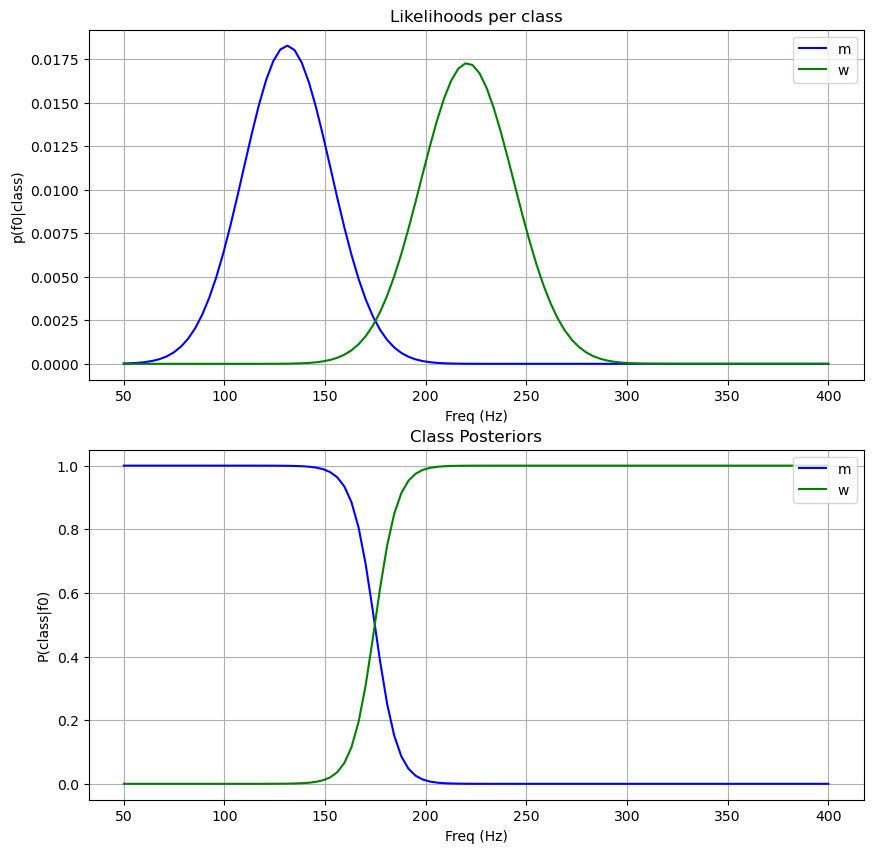

In [10]:
# have a look at the internals of the classifier
# by looking at likelihoods per class and 
# predicted probabilities per class over the whole pitch range
x = np.vstack(np.linspace(50.,400.,100))
fig,ax = plt.subplots(2,1,figsize=(10,10))

# 1. likelihoods
z = clf_GMM.predict_prob(x)
h = ax[0].plot(x,z,marker="")
ax[0].set_xlabel("Freq (Hz)")
ax[0].set_ylabel("p(f0|class)")
ax[0].legend(classes,loc='upper right')
ax[0].grid(True)
ax[0].set_title("Likelihoods per class")
# 2. posteriors
z = clf_GMM.predict_proba(x)
h = ax[1].plot(x,z)
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("P(class|f0)")
ax[1].legend(classes,loc='upper right')
ax[1].grid(True)
ax[1].set_title("Class Posteriors")
plt.show()

### Evaluate on your test samples

We can compute the likelihoods on the gaussians up to high precision by using the formulas of a Gaussian distribution.  With a trained model and distributions plotted as above we can also **read** the likelihoods from the graphs.   This will serve as well for didactical purposes.

If we don't have a plot of our actual distributions, there is one ultimate simple method that comes to the rescue.  We can convert our distribution to a **standard normal** distribution if we simlpy express our samples in z-scores:
$$
z = \frac{x-\mu}{\sigma}
$$
and read the likelihoods from the standard normal plots included below   ... thus, no need for a calculator computing exponential functions

#### Task & Questions (3)
1. For your personal test set, compute likelihoods and class probabilities using the standard normal model
2. Verify your results with the values below
3. Given your classifier, can you make a prediction on the global error rate ? 
8. Include 135Hz and 145Hz in the test samples.  First, observe that in the full Hillenbrand database the lowest female pitch is 149Hz. What would your intuitive answer (guess) be on classification and posteriors.  Now observe the predictions given by the model. How do you explain the rather big differences beween the two predicted posteriors ?

<img src="../figures/standard_normal.png" style="height:20cm"/>

In [43]:
#
my_test = np.array([89., 135., 145., 150., 180. , 210., 240., 288., 300.]).reshape(-1,1)
priors=None
print("Likelihoods")
print(clf_GMM.predict_prob(my_test))
print("Class Probabilities")
print(clf_GMM.predict_proba(my_test,priors=priors))
print("Recognized Classes")
print(clf_GMM.predict(my_test,priors=priors))

Likelihoods
[[2.54e-03 4.27e-10]
 [1.89e-02 1.03e-05]
 [1.51e-02 5.27e-05]
 [1.24e-02 1.10e-04]
 [1.07e-03 3.26e-03]
 [1.10e-05 1.58e-02]
 [1.35e-08 1.25e-02]
 [3.56e-15 2.00e-04]
 [3.45e-17 3.45e-05]]
Class Probabilities
[[1.00e+00 1.71e-07]
 [9.99e-01 5.54e-04]
 [9.96e-01 3.54e-03]
 [9.91e-01 9.02e-03]
 [2.43e-01 7.57e-01]
 [6.85e-04 9.99e-01]
 [1.06e-06 1.00e+00]
 [1.75e-11 1.00e+00]
 [9.80e-13 1.00e+00]]
Recognized Classes
['m', 'm', 'm', 'm', 'w', 'w', 'w', 'w', 'w']


### Detailed Computations using z-scores
In the cells above we make use of functionality in the GMM class for Gaussian Mixture Modeling.  We can querry the model for likelihoods, class probabilities and recognized class.

Below we basically do the same computations in all detail for a single Gaussian model:
1. put the estimated parameters in **mu** and **sig** arrays 
2. compute the z-values, i.e. centered and normalized deviation from the mean
3. compute the per class likelihoods
4. compute the total sample likelihood
5. Use Bayes rule to convert the likelihoods to class probabilities

(we assume equal likelihoods = 0.5)

In [12]:
# make it a bit more readable for the detailed computations
# we just make an array of class means and class standard deviations
mu = np.array([clf_GMM.gmm[i].means_[0][0] for i in [0,1]])
sig = np.array([np.sqrt(clf_GMM.gmm[i].covariances_[0][0]) for i in [0,1]])
np.set_printoptions(precision=4)
print("model parameters (means and std dev's):",mu,sig)

model parameters (means and std dev's): [131.1767 220.6631] [21.8307 23.0988]


In [13]:
# compute the z values
p=np.array([0.,0.])
z=np.array([0.,0.])
pclass=np.array([0.,0.])
sqrt2pi = np.sqrt(2*np.pi)

for x in my_test.flatten():
    print("Test Sample: ",x)
    z = (x-mu)/sig
    print("   Z-values: ",z)
    # compute the likelihoods on each distribution
    for i in [0,1]:
        p[i] = np.exp(-.5*z[i]*z[i])/(sqrt2pi)
    print("   Likelihoods for sample for each class: ",p)
    # total likelihood  (0.5 priors)
    px = 0.5 * np.sum(p)
    print("   Total Sample Likelihood:",px)
    # class posteriors
    for i in [0,1]:
        pclass[i] = 0.5 * p[i] / px
    print("   Class Probabilities(posteriors): ",pclass)

Test Sample:  89.0
   Z-values:  [-1.932 -5.7  ]
   Likelihoods for sample for each class:  [6.1715e-02 3.5143e-08]
   Total Sample Likelihood: 0.0308576868948303
   Class Probabilities(posteriors):  [1.0000e+00 5.6943e-07]
Test Sample:  135.0
   Z-values:  [ 0.1751 -3.7085]
   Likelihoods for sample for each class:  [0.3929 0.0004]
   Total Sample Likelihood: 0.19664116697068296
   Class Probabilities(posteriors):  [0.999 0.001]
Test Sample:  145.0
   Z-values:  [ 0.6332 -3.2756]
   Likelihoods for sample for each class:  [0.3265 0.0019]
   Total Sample Likelihood: 0.16416902263694882
   Class Probabilities(posteriors):  [0.9943 0.0057]
Test Sample:  160.0
   Z-values:  [ 1.3203 -2.6262]
   Likelihoods for sample for each class:  [0.1669 0.0127]
   Total Sample Likelihood: 0.08977603988618274
   Class Probabilities(posteriors):  [0.9294 0.0706]
Test Sample:  175.0
   Z-values:  [ 2.0074 -1.9769]
   Likelihoods for sample for each class:  [0.0532 0.0565]
   Total Sample Likelihood: 0.0